# Notional Example Problem

An analytic problem for understanding resilience optimization structures.

In [17]:
import sys
sys.path.append('../')
import numpy as np
import scipy as sp
import time
import itertools
import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint

This problem considers different architectures to structure the optimization of resilience. In general, the resilience of a system is a function of the performance curve which results from a given hazardous scenario. Consider, for example, the curve shown below, where a fault causes the system to perform in a worse condition (given by $x_a$) for a given amount of time $x_b$, before it is recovered over a given amount of time $x_c$.

<h3 align="center">System Resilience to Considered Fault Scenario</h3> 

![Resilience of the System to Fault](notionalsystem.png)

In an integrated resilience optimization formulation of this problem, the goal is to optimize the design/operations of the system with the resilience variables simultaneously to balance the resilience of the system with design/operational considerations. This involves (at least) two models of cost: design/operational cost and resilience cost.

## Design/Operational Cost

The design model specifies the inherent resilience in the system that results from the way it was designed/is operated when there is no hazardous scenario. In this model, the variables are $x_p$, the overall performance of the system, $x_a$, the lost performance during the scenario, $x_s$, the slack in the system, and $x_r$, the hazard rate. The terms a-f and n are constants.

In [460]:
xdes = [1,0.5,1e-4,0.5]
xdb = ((1e-6,100),(0,2),(1e-10,100),(0,2))
# xdes = [x_p, x_a, x_r, x_s]
# index:   0    1    2    3
# constants: [a,b,c,n,d,e,f]
# inds:       0,1,2,3,4,5,6
const =[1e6,5e5,100,1e5,50,50,20]

The Design/Operational cost model for this system is: $C_D = - a \sqrt{x_a + 0.1} -b \sqrt{ x_s +0.1} + \frac{c}{x_r}$ 

The terms in the cost model captures the value of having increased performance, the waste of running the system with excess slack, and the cost of maintaining the system at a certain level of reliability.

In [461]:
def des_cost(xdes,const):
    return  - const[0]*np.sqrt(xdes[1] + 0.1) - const[1]* np.sqrt(xdes[3] +0.1) + const[2]/max(xdes[2], 1e-6)

Subject to the equality constraint: $h_D = x_p -(x_s + x_a) = 0$, which captures the relationship between slack, performance, and lost performance during the scenario.

In [462]:
def des_h_const(xdes):
    return xdes[0]-(xdes[3]+xdes[1])

There is also an inequality constraint: $g_D = (x_p-1)^2/c - x_r$, which specifies a lower bound on how reliable the system can be when performance deviates from the target needed for peak reliability.

In [463]:
def des_g_const(xdes):
    return (xdes[0]-1)**2/const[2] - xdes[2]

## Resilience Model

The resilience model specifies how the system performes in the hazardous scenario(s) based on variables which may be leveraged during this scenario. In this system, there are two variables--$x_b$, the length of time the system stays in the hazardous scenario before it is repaired, and $x_c$, the length of time it takes to repair the system.

In [464]:
xres = [1,  1]
#ind:   0   1
#full:  4   5
#lab:   x_b,x_c
xrb = ((1e-6,100), (1e-6,100))

In this system, the resilience model is specified with a cost function:

$C_R = x_r*n*(d*x_a*(x_b+x_c/2) + e/x_c + f/x_b))$

which considers the cost as a function of the area between the nominal performance and the resilience curve (the cost of the hazard's direct consequences), along with a cost of short recovery time and a cost of short repair time (the cost of restoring the system to nominal performance at a certain speed).

In [465]:
def res_cost(xres,xdes,const):
    return xdes[2] * const[3] * (const[4]*xdes[1]*((xres[0]+xres[1]/2) + const[5]/max(xres[1],1e-6))+const[6]/max(xres[0],1e-6))

## Optimization Architectures

This problem can be solved using a number of solution architectures. This section presents and compares the all-at-once, bilevel, and alternating optimization structures.


<h3 align="center">All-at-once Architecture</h3> 

![All-at-once Architecture](allatonce.png)

The all-at-once architecture is an optimization strategy where the entire problem is solved in a single *monolithic* formulation, with the overall objective $C = C_D + C_R$

In [466]:
def x_to_totcost_mono(x, const):
    return des_cost(x, const) + res_cost(x[4:],x, const)

In [467]:
#used to keep track of optimization progress
history = []
def callbackF(Xdes, result):
    history.append(result['fun'])

Below, the trust-region constrained algorithm is used to optimize this problem. As implemented, the algorithm does not reach a convergence criteria and instead finishes after reaching the maximum number of steps (1000)

In [468]:
# all-in-one 
x = xdes + xres
xb = xdb + xrb
history = []
starttime = time.time()
constraints = [{'type':'eq', 'fun': lambda x: -(x[0]-(x[3]+x[1])), 'jac': lambda x: np.array([1,-1,0,-1,0,0])}, {'type':'ineq', 'fun': lambda x: -((x[0]-1)**2/const[2]-x[2]), 'jac': lambda x: -np.array([2*(x[0]-1)/const[2], 0, -1, 0,0,0]) }]
constraints = [{'type':'eq', 'fun': lambda x: -(x[0]-(x[3]+x[1]))}, {'type':'ineq', 'fun': lambda x: -((x[0]-1)**2/const[2]-x[2]) }]

result_aao = minimize(x_to_totcost_mono, x, method='trust-constr', bounds = xb, constraints =constraints, args = const, callback=callbackF, options={'maxiter':1e4, 'verbose':2}) 
time_aao = time.time() - starttime
aao_history = history

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   7   |   0   | -1.4882e+05 | 1.00e+00 | 3.29e+09 | 0.00e+00 |
|   2   |  14   |   1   | -1.4882e+05 | 5.00e-01 | 3.29e+09 | 0.00e+00 |
|   3   |  21   |   2   | -1.4882e+05 | 2.50e-01 | 3.29e+09 | 0.00e+00 |
|   4   |  28   |   3   | -1.4882e+05 | 1.25e-01 | 3.29e+09 | 0.00e+00 |
|   5   |  35   |   4   | -1.4882e+05 | 6.25e-02 | 3.29e+09 | 0.00e+00 |
|   6   |  42   |   5   | -1.4882e+05 | 3.12e-02 | 3.29e+09 | 0.00e+00 |
|   7   |  49   |   6   | -1.4882e+05 | 1.56e-02 | 3.29e+09 | 0.00e+00 |
|   8   |  56   |   7   | -4.2813e+05 | 1.56e-02 | 4.28e+07 | 4.10e-05 |
|   9   |  63   |   8   | -4.2813e+05 | 1.56e-03 | 4.28e+07 | 4.10e-05 |
|  10   |  70   |   9   | -4.9766e+05 | 1.09e-02 | 4.25e+07 | 4.52e-05 |
|  11   |  77   |  10   | -9.2738e+05 | 2.19e-02 | 1.58e+07 | 7.41e-05 |
|  12   |  84   |  15   | -9.2738e+05 | 2.19e-03 | 

|  141  | 1211  |  429  | -1.2574e+06 | 1.00e-06 | 1.30e-03 | 0.00e+00 |
|  142  | 1225  |  432  | -1.2574e+06 | 1.00e-07 | 1.30e-03 | 0.00e+00 |
|  143  | 1239  |  435  | -1.2574e+06 | 1.00e-08 | 1.30e-03 | 0.00e+00 |
|  144  | 1253  |  438  | -1.2574e+06 | 1.00e-09 | 1.30e-03 | 0.00e+00 |
|  145  | 1260  |  438  | -1.2574e+06 | 1.00e+00 | 1.30e-03 | 0.00e+00 |
|  146  | 1260  |  439  | -1.2574e+06 | 1.00e-01 | 1.30e-03 | 0.00e+00 |
|  147  | 1260  |  440  | -1.2574e+06 | 1.00e-02 | 1.30e-03 | 0.00e+00 |
|  148  | 1260  |  441  | -1.2574e+06 | 1.00e-03 | 1.30e-03 | 0.00e+00 |
|  149  | 1260  |  442  | -1.2574e+06 | 1.00e-04 | 1.30e-03 | 0.00e+00 |
|  150  | 1260  |  443  | -1.2574e+06 | 1.00e-05 | 1.30e-03 | 0.00e+00 |
|  151  | 1260  |  444  | -1.2574e+06 | 1.00e-06 | 1.30e-03 | 0.00e+00 |
|  152  | 1260  |  445  | -1.2574e+06 | 1.00e-07 | 1.30e-03 | 0.00e+00 |
|  153  | 1260  |  446  | -1.2574e+06 | 1.00e-08 | 1.30e-03 | 0.00e+00 |
|  154  | 1260  |  447  | -1.2574e+06 | 1.00e-09 | 

In [469]:
result_aao['x']

array([1.46423824e+00, 1.05595200e+00, 2.15517142e-03, 4.08286237e-01,
       6.15471379e-01, 9.99999964e+00])

In [470]:
result_aao['fun']

-1257428.5235685816

In [471]:
time_aao

0.43772459030151367

In [472]:
times_aao = np.linspace(0,1,len(aao_history))*time_aao

<h3 align="center">Bilevel Architecture</h3> 

![Bilevel Architecture](bilevel.png)

In the bilevel architecture, the optimization of the resilience model is nested inside the optimization of the design model.

In [562]:
def bi_upper_level(xdes, args):
    const = args['const']
    xres = args['xres']
    dcost = des_cost(xdes, const)
    xrb =  ((0.0001,100), (0.0001,100))
    ll_result = minimize(res_cost, [round(xres[0],2),round(xres[1],2)], method='trust-constr', bounds = xrb, args = (xdes, const), options={'maxiter':20, 'verbose':1})
    args['xres'] = ll_result['x']
    rcost = ll_result['fun']
    return rcost + dcost

# just design cost variables.
#constraints_des = [{'type':'eq', 'fun': lambda x: x[0]-(x[3]+x[1]), 'jac': lambda x: np.array([1,-1,0,-1])}, {'type':'ineq', 'fun': lambda x: -((x[0]-1)**2/const[2]-x[2]), 'jac': lambda x: -np.array([2*(x[0]-1)/const[2], 0, -1, 0]) }]
constraints_des = [{'type':'eq', 'fun': lambda x: x[0]-(x[3]+x[1])}, {'type':'ineq', 'fun': lambda x: -((x[0]-1)**2/const[2]-x[2])}]

In [563]:
round(1.234)

1

In this approach, we again use the trust region-constrained algorithm, this time with a max number of iterations of 100 in the upper level and 10 in the lower level (for rough parity with the all-in-one algorithm).

In [564]:
history = []
starttime = time.time()
args = {'const':const, 'xres':[1,1]}
result_bi = minimize(bi_upper_level, xdes, method='trust-constr', bounds = xdb, constraints =constraints_des, args = args, callback=callbackF, options={'maxiter':50, 'verbose':2})
#, hess= lambda x,y: [0,0,0,0]
time_bi = time.time() - starttime
bi_history = history

The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 63, CG iterations: 38, optimality: 3.43e-02, constraint violation: 0.00e+00, execution time: 0.07 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 19, optimality: 5.93e-06, constraint violation: 0.00e+00, execution time: 0.048 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 18, optimality: 6.30e-07, constraint violation: 0.00e+00, execution time: 0.05 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 19, optimality: 2.40e-05, constraint violation: 0.00e+00, execution time: 0.065 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 19, optimality: 5.93e-06, constraint violation: 0.00e+00, execution time: 0.055 s.
| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   5   |   0   | -1.5895e+05 | 1.00e+00 | 3.32e+09 | 0.00e+00 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 60, CG iterations: 32, optimality: 1.98e-01, constraint violation: 0.00e+00, execution time: 0.065 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 26, optimality: 9.42e-02, constraint violation: 0.00e+00, execution time: 0.042 s.
`gtol` termination condition is satisfied.
Number of iterations: 21, function evaluations: 33, CG iterations: 17, optimality: 5.00e-09, constraint violation: 0.00e

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 27, optimality: 9.42e-02, constraint violation: 0.00e+00, execution time: 0.046 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 26, optimality: 9.42e-02, constraint violation: 0.00e+00, execution time: 0.042 s.
|   2   |  10   |   1   | -1.5895e+05 | 5.00e-01 | 3.32e+09 | 0.00e+00 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 36, CG iterations: 16, optimality: 2.52e-08, constraint violation: 0.00e+00, execution time: 0.051 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 60, CG iterations: 32, optimality: 1.79e-02, constraint violation: 0.00e+00, execution time: 0.046 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations:

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 24, optimality: 6.30e-07, constraint violation: 0.00e+00, execution time: 0.056 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 28, optimality: 1.79e-02, constraint violation: 0.00e+00, execution time: 0.053 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 27, optimality: 1.59e-02, constraint violation: 0.00e+00, execution time: 0.05 s.
|   4   |  20   |   3   | -1.5895e+05 | 1.25e-01 | 3.32e+09 | 0.00e+00 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 54, CG iterations: 30, optimality: 6.55e-03, constraint violation: 0.00e+00, execution time: 0.053 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 54, CG iterations: 30, optimality: 6.55e-03, constraint violation: 0.00e+00, execution time: 0.054 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 54, CG iterations: 31, optimality: 1.62e-03, constraint violation: 0.00e+00, execution time: 0.058 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 23, optimality: 6.30e-07, constraint violation: 0.00e+00, execution time: 0.058 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 54, CG iterations: 30, optimality: 6.55e-03, constraint violation: 0.00e+00, execution time: 0.06 s.
|   5   |  25   |   4   | -1.5895e+05 | 6.25e-02 | 3.32e+09 | 0.00e+00 |


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 32, optimality: 1.48e-03, constraint violation: 0.00e+00, execution time: 0.051 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 32, optimality: 1.48e-03, constraint violation: 0.00e+00, execution time: 0.051 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 31, optimality: 1.48e-03, constraint violation: 0.00e+00, execution time: 0.05 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 29, optimality: 7.59e-04, constraint violation: 0.00e+00, execution time: 0.051 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 32, optimality: 1.48e-03, constraint violation: 0.00e+00, execution time: 0.049 s.
|   6   |  30   |   5   | -5.2295e+05 | 6.25e-02 | 1.00e+07 | 2.31e-04 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 63, CG iterations: 23, optimality: 4.13e+00, constraint violation: 0.00e+00, execution time: 0.063 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 63, CG iterations: 21, optimality: 1.46e+01, constraint violation: 1.68e-12, execution time: 0.054 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 63, CG iterations: 21, optimality: 3.17e+01, constraint violation: 1.10e-11, execution time: 0.053 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 63, CG iterations: 22, optimality: 3.81e+01, constraint violation: 0.00e+00, execution time: 0.059 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 63, CG iterations: 22, optimality: 7.26e+01, constraint violation: 6.14e-11, execution time: 0.056 s.
|   7   |  35   |   6   | -5.2295e+05 | 6.25e-03 | 1.00e+07 | 2.31e-04 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 66, CG iterations: 38, optimality: 2.87e+04, constraint violation: 0.00e+00, execution time: 0.072 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 28, optimality: 7.88e-05, constraint violation: 0.00e+00, execution time: 0.065 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 27, optimality: 3.08e-03, constraint violation: 0.00e+00, execution time: 0.051 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 24, optimality: 3.08e-03, constraint violation: 0.00e+00, execution time: 0.05 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 24, optimality: 3.08e-03, constraint violation: 0.00e+00, execution time: 0.051 s.
|   8   |  40   |   7   | -5.3127e+05 | 6.25e-03 | 2.99e+12 | 2.55e-04 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 23, optimality: 3.07e-03, constraint violation: 0.00e+00, execution time: 0.052 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 23, optimality: 3.07e-03, constraint violation: 0.00e+00, execution time: 0.049 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 54, CG iterations: 25, optimality: 6.54e-03, constraint violation: 0.00e+00, execution time: 0.055 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 36, CG iterations: 17, optimality: 2.52e-08, constraint violation: 0.00e+00, execution time: 0.055 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 23, optimality: 3.07e-03, constraint violation: 0.00e+00, execution time: 0.045 s.
|   9   |  45   |   8   | -5.6132e+05 | 6.25e-03 | 1.00e+07 | 2.79e-04 |


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 36, CG iterations: 24, optimality: 4.96e-03, constraint violation: 0.00e+00, execution time: 0.045 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 36, CG iterations: 24, optimality: 4.96e-03, constraint violation: 0.00e+00, execution time: 0.046 s.
`gtol` termination condition is satisfied.
Number of iterations: 21, function evaluations: 33, CG iterations: 17, optimality: 5.04e-09, constraint violation: 0.00e+00, execution time: 0.053 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 24, optimality: 3.86e-03, constraint violation: 0.00e+00, execution time: 0.048 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 36, CG iterations: 24, optimality: 4.96e-03, constraint violation: 0.00e+00, executio

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


`gtol` termination condition is satisfied.
Number of iterations: 21, function evaluations: 33, CG iterations: 16, optimality: 5.04e-09, constraint violation: 0.00e+00, execution time: 0.058 s.
`gtol` termination condition is satisfied.
Number of iterations: 20, function evaluations: 30, CG iterations: 15, optimality: 5.04e-09, constraint violation: 0.00e+00, execution time: 0.047 s.
|  11   |  55   |  12   | -1.0180e+06 | 3.06e-01 | 8.07e+06 | 4.72e-04 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 63, CG iterations: 22, optimality: 1.57e+05, constraint violation: 0.00e+00, execution time: 0.058 s.
`gtol` termination condition is satisfied.
Number of iterations: 21, function evaluations: 60, CG iterations: 24, optimality: 1.60e-09, constraint violation: 0.00e+00, execution time: 0.065 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


`gtol` termination condition is satisfied.
Number of iterations: 9, function evaluations: 24, CG iterations: 11, optimality: 8.50e-09, constraint violation: 0.00e+00, execution time: 0.03 s.
`gtol` termination condition is satisfied.
Number of iterations: 9, function evaluations: 24, CG iterations: 11, optimality: 8.50e-09, constraint violation: 0.00e+00, execution time: 0.029 s.
`gtol` termination condition is satisfied.
Number of iterations: 9, function evaluations: 24, CG iterations: 11, optimality: 8.50e-09, constraint violation: 0.00e+00, execution time: 0.028 s.
|  12   |  60   |  15   | -1.0180e+06 | 3.06e-02 | 8.07e+06 | 4.72e-04 |
`gtol` termination condition is satisfied.
Number of iterations: 6, function evaluations: 18, CG iterations: 8, optimality: 9.50e-09, constraint violation: 0.00e+00, execution time: 0.018 s.
`gtol` termination condition is satisfied.
Number of iterations: 6, function evaluations: 18, CG iterations: 8, optimality: 9.50e-09, constraint violation: 0.00e

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 75, CG iterations: 36, optimality: 3.93e+03, constraint violation: 0.00e+00, execution time: 0.057 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 66, CG iterations: 39, optimality: 7.32e+03, constraint violation: 0.00e+00, execution time: 0.062 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 63, CG iterations: 38, optimality: 7.33e-03, constraint violation: 0.00e+00, execution time: 0.061 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 25, optimality: 3.53e-04, constraint violation: 0.00e+00, execution time: 0.055 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 36, CG iterations: 23, optimality: 9.39e-05, constraint violation: 0.00e

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


`gtol` termination condition is satisfied.
Number of iterations: 20, function evaluations: 30, CG iterations: 15, optimality: 5.04e-09, constraint violation: 0.00e+00, execution time: 0.05 s.
|  15   |  75   |  21   | -1.0218e+06 | 3.48e-03 | 7.91e+06 | 4.74e-04 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 26, optimality: 7.85e-04, constraint violation: 0.00e+00, execution time: 0.048 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 26, optimality: 7.85e-04, constraint violation: 0.00e+00, execution time: 0.056 s.
`gtol` termination condition is satisfied.
Number of iterations: 21, function evaluations: 33, CG iterations: 16, optimality: 5.04e-09, constraint violation: 0.00e+00, execution time: 0.053 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 36, CG iterations: 18, optimality: 2.52e-08, constraint violation: 0.00e+00, execution time: 0.055 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 26, optimality: 7.85e-04, constraint violation: 0.00e+00, execution time: 0.05 s.
|  16   |  80   |  23   | -1.0222e+06 | 1.95e-02 | 7.90e+06 | 4.88e-04 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 25, optimality: 1.79e-04, constraint violation: 0.00e+00, execution time: 0.06 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 25, optimality: 1.79e-04, constraint violation: 0.00e+00, execution time: 0.059 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

`gtol` termination condition is satisfied.
Number of iterations: 21, function evaluations: 33, CG iterations: 15, optimality: 5.04e-09, constraint violation: 0.00e+00, execution time: 0.052 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 28, optimality: 7.85e-04, constraint violation: 0.00e+00, execution time: 0.054 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 25, optimality: 1.79e-04, constraint violation: 0.00e+00, execution time: 0.054 s.
|  17   |  85   |  26   | -1.0280e+06 | 1.09e-01 | 7.62e+06 | 5.65e-04 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 63, CG iterations: 20, optimality: 4.83e+03, constraint violation: 0.00e+00, execution time: 0.065 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


`gtol` termination condition is satisfied.
Number of iterations: 18, function evaluations: 54, CG iterations: 21, optimality: 1.49e-10, constraint violation: 0.00e+00, execution time: 0.058 s.
`gtol` termination condition is satisfied.
Number of iterations: 5, function evaluations: 15, CG iterations: 7, optimality: 2.72e-10, constraint violation: 0.00e+00, execution time: 0.016 s.
`gtol` termination condition is satisfied.
Number of iterations: 5, function evaluations: 15, CG iterations: 7, optimality: 2.72e-10, constraint violation: 0.00e+00, execution time: 0.017 s.
`gtol` termination condition is satisfied.
Number of iterations: 5, function evaluations: 15, CG iterations: 7, optimality: 2.72e-10, constraint violation: 0.00e+00, execution time: 0.017 s.
|  18   |  90   |  29   | -1.0280e+06 | 1.09e-02 | 7.62e+06 | 5.65e-04 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 78, CG iterations: 29, optimality: 4.42e+02, constraint v

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 63, CG iterations: 38, optimality: 5.56e+02, constraint violation: 0.00e+00, execution time: 0.06 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 27, optimality: 3.82e-05, constraint violation: 0.00e+00, execution time: 0.071 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 21, optimality: 1.26e-05, constraint violation: 0.00e+00, execution time: 0.056 s.
|  19   |  95   |  31   | -1.0280e+06 | 3.01e-03 | 7.62e+06 | 5.65e-04 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 23, optimality: 7.84e-04, constraint violation: 0.00e+00, execution time: 0.054 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 23, optimality: 7.84e-04, constraint violation: 0.00e+00, execution time: 0.053 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 25, optimality: 3.53e-04, constraint violation: 0.00e+00, execution time: 0.058 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 27, optimality: 4.16e-04, constraint violation: 0.00e+00, execution time: 0.058 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 23, optimality: 7.84e-04, constraint violation: 0.00e+00, execution time: 0.053 s.
|  20   |  100  |  33   | -1.0473e+06 | 2.11e-02 | 5.82e+06 | 5.77e-04 |


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 25, optimality: 4.55e-05, constraint violation: 0.00e+00, execution time: 0.054 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 25, optimality: 4.55e-05, constraint violation: 0.00e+00, execution time: 0.051 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 22, optimality: 5.69e-04, constraint violation: 0.00e+00, execution time: 0.048 s.
`gtol` termination condition is satisfied.
Number of iterations: 21, function evaluations: 33, CG iterations: 15, optimality: 5.04e-09, constraint violation: 0.00e+00, execution time: 0.052 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 25, optimality: 4.55e-05, constraint violation: 0.00e+00, execution time: 0.058 s.
|  21   |  105  |  36   | -1.0578e+06 | 1.21e-01 | 5.73e+05 | 6.62e-04 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 36, CG iterations: 27, optimality: 9.39e-05, constraint violation: 0.00e+00, execution time: 0.047 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 36, CG iterations: 27, optimality: 9.39e-05, constraint violation: 0.00e+00, execution time: 0.05 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 21, optimality: 2.00e-04, constraint violation: 0.00e+00, execution time: 0.049 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 22, optimality: 3.15e-06, constraint violation: 0.00e+00, execution time: 0.059 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 22, optimality: 2.00e-04, constraint violation: 0.00e+00, execution time: 0.056 s.
|  23   |  115  |  41   | -1.0577e+06 | 1.08e+00 | 2.67e+06 | 1.99e-03 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 24, optimality: 1.58e-05, constraint violation: 0.00e+00, execution time: 0.053 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 33, optimality: 5.84e-03, constraint violation: 0.00e+00, execution time: 0.051 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 34, optimality: 4.61e-02, constraint violation: 0.00e+00, execution time: 0.048 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 31, optimality: 5.79e-02, constraint violation: 0.00e+00, execution time: 0.051 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 33, optimality: 5.84e-03, constraint violation: 0.00e+00, execution time: 0.05 s.
|  24   |  120  |  43   | +5.4324e+06 | 7.57e+00 | 3.24e+06 | 8.03e-04 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 24, optimality: 6.31e-07, constraint violation: 0.00e+00, execution time: 0.053 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 26, optimality: 4.67e-02, constraint violation: 0.00e+00, execution time: 0.045 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 34, optimality: 4.67e-02, constraint violation: 0.00e+00, execution time: 0.048 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 60, CG iterations: 33, optimality: 4.67e-02, constraint violation: 0.00e+00, execution time: 0.052 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 26, optimality: 4.67e-02, constraint violation: 0.00e+00, execution time: 0.047 s.
|  25   |  125  |  46   | +1.0297e+07 | 7.57e+00 | 2.68e+06 | 1.11e-16 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations:

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 28, optimality: 4.68e-02, constraint violation: 0.00e+00, execution time: 0.05 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 26, optimality: 5.47e-02, constraint violation: 0.00e+00, execution time: 0.043 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 21, optimality: 1.26e-07, constraint violation: 0.00e+00, execution time: 0.06 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 28, optimality: 4.68e-02, constraint violation: 0.00e+00, execution time: 0.051 s.
|  26   |  130  |  49   | +1.0170e+07 | 7.57e+00 | 2.66e+06 | 1.11e-16 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 5

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 24, optimality: 2.29e-02, constraint violation: 0.00e+00, execution time: 0.051 s.
`gtol` termination condition is satisfied.
Number of iterations: 20, function evaluations: 30, CG iterations: 14, optimality: 5.03e-09, constraint violation: 0.00e+00, execution time: 0.048 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 24, optimality: 5.80e-03, constraint violation: 0.00e+00, execution time: 0.044 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 24, optimality: 5.80e-03, constraint violation: 0.00e+00, execution time: 0.043 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 57, CG iterations: 27, optimality: 1.36e-02, constraint violation: 0.00e+00, executio

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 54, CG iterations: 25, optimality: 5.71e-04, constraint violation: 0.00e+00, execution time: 0.061 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 19, optimality: 1.24e-07, constraint violation: 0.00e+00, execution time: 0.057 s.
|  28   |  145  |  55   | -8.3855e+05 | 1.15e+01 | 5.01e+04 | 9.10e-15 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 25, optimality: 1.53e-03, constraint violation: 0.00e+00, execution time: 0.053 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 26, optimality: 1.79e-04, constraint violation: 0.00e+00, execution time: 0.049 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations:

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 23, optimality: 2.30e-03, constraint violation: 0.00e+00, execution time: 0.049 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 26, optimality: 1.79e-04, constraint violation: 0.00e+00, execution time: 0.05 s.
|  29   |  150  |  58   | -8.5125e+05 | 1.15e+01 | 5.13e+04 | 0.00e+00 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 26, optimality: 4.55e-05, constraint violation: 0.00e+00, execution time: 0.054 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 25, optimality: 3.92e-04, constraint violation: 0.00e+00, execution time: 0.049 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 26, optimality: 9.39e-05, constraint violation: 0.00e+00, execution time: 0.054 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 24, optimality: 4.55e-05, constraint violation: 0.00e+00, execution time: 0.052 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 25, optimality: 3.92e-04, constraint violation: 0.00e+00, execution time: 0.049 s.
|  30   |  155  |  61   | -9.5455e+05 | 1.15e+01 | 6.48e+04 | 7.37e-14 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 29, optimality: 4.06e-04, constraint violation: 0.00e+00, execution time: 0.056 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 22, optimality: 8.26e-05, constraint violation: 0.00e+00, execution time: 0.052 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 25, optimality: 4.06e-04, constraint violation: 0.00e+00, execution time: 0.053 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 36, CG iterations: 17, optimality: 2.51e-08, constraint violation: 0.00e+00, execution time: 0.054 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 22, optimality: 8.26e-05, constraint violation: 0.00e+00, execution time: 0.049 s.
|  31   |  160  |  64   | -9.9092e+05 | 1.15e+01 | 7.34e+04 | 0.00e+00 |


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 28, optimality: 9.39e-05, constraint violation: 0.00e+00, execution time: 0.063 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 19, optimality: 6.11e-07, constraint violation: 0.00e+00, execution time: 0.056 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 17, optimality: 1.22e-07, constraint violation: 0.00e+00, execution time: 0.056 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 23, optimality: 2.78e-04, constraint violation: 0.00e+00, execution time: 0.054 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 19, optimality: 6.11e-07, constraint violation: 0.00e+00, execution time: 0.056 s.
|  32   |  165  |  67   | -1.0853e+06 | 1.16e+01 | 9.17e+04 | 3.04e-13 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 28, optimality: 3.79e-04, constraint violation: 0.00e+00, execution time: 0.06 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 20, optimality: 5.89e-07, constraint violation: 0.00e+00, execution time: 0.055 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 23, optimality: 1.38e-04, constraint violation: 0.00e+00, execution time: 0.056 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 18, optimality: 1.18e-07, constraint violation: 0.00e+00, execution time: 0.056 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 36, CG iterations: 17, optimality: 2.36e-08, constraint violation: 0.00e+00, execution time: 0.055 s.
|  33   |  175  |  70   | -1.0853e+06 | 1.16e+00 | 9.17e+04 | 3.04e-13 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 28, optimality: 4.86e-04, constraint violation: 0.00e+00, execution time: 0.063 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 19, optimality: 1.15e-07, constraint violation: 0.00e+00, execution time: 0.054 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 19, optimality: 1.15e-07, constraint violation: 0.00e+00, execution time: 0.057 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 27, optimality: 1.79e-04, constraint violation: 0.00e+00, execution time: 0.054 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 19, optimality: 1.15e-07, constraint violation: 0.00e+00, execution time: 0.055 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 22, optimality: 7.65e-04, constraint violation: 0.00e+00, execution time: 0.055 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 22, optimality: 7.65e-04, constraint violation: 0.00e+00, execution time: 0.056 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 22, optimality: 1.44e-05, constraint violation: 0.00e+00, execution time: 0.056 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 25, optimality: 7.18e-05, constraint violation: 0.00e+00, execution time: 0.056 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 22, optimality: 7.65e-04, constraint violation: 0.00e+00, execution time: 0.056 s.
|  34   |  185  |  73   | -1.0853e+06 | 4.21e-01 | 9.17e+04 | 3.04e-13 |


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 24, optimality: 1.51e-05, constraint violation: 0.00e+00, execution time: 0.058 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 23, optimality: 2.62e-04, constraint violation: 0.00e+00, execution time: 0.049 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 22, optimality: 1.54e-04, constraint violation: 0.00e+00, execution time: 0.054 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 23, optimality: 2.62e-04, constraint violation: 0.00e+00, execution time: 0.051 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 23, optimality: 2.62e-04, constraint violation: 0.00e+00, execution time: 0.048 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 22, optimality: 1.54e-04, constraint violation: 0.00e+00, execution time: 0.052 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 22, optimality: 1.54e-04, constraint violation: 0.00e+00, execution time: 0.051 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 23, optimality: 3.02e-06, constraint violation: 0.00e+00, execution time: 0.057 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 19, optimality: 1.21e-07, constraint violation: 0.00e

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 26, optimality: 4.55e-05, constraint violation: 0.00e+00, execution time: 0.056 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 24, optimality: 1.91e-04, constraint violation: 0.00e+00, execution time: 0.059 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 24, optimality: 9.39e-05, constraint violation: 0.00e+00, execution time: 0.054 s.
|  36   |  200  |  78   | -1.0957e+06 | 2.94e+00 | 9.25e+04 | 1.87e-14 |
`gtol` termination condition is satisfied.
Number of iterations: 21, function evaluations: 33, CG iterations: 14, optimality: 4.78e-09, constraint violation: 0.00e+00, execution time: 0.052 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


`gtol` termination condition is satisfied.
Number of iterations: 21, function evaluations: 33, CG iterations: 14, optimality: 4.78e-09, constraint violation: 0.00e+00, execution time: 0.053 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 22, optimality: 1.46e-04, constraint violation: 0.00e+00, execution time: 0.055 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 23, optimality: 1.76e-04, constraint violation: 0.00e+00, execution time: 0.056 s.
`gtol` termination condition is satisfied.
Number of iterations: 21, function evaluations: 33, CG iterations: 14, optimality: 4.78e-09, constraint violation: 0.00e+00, execution time: 0.046 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 22, optimality: 1.42e-04, constraint violation: 0.00e+00, execution time: 0.056 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 22, optimality: 1.42e-04, constraint violation: 0.00e+00, execution time: 0.054 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 36, CG iterations: 16, optimality: 2.39e-08, constraint violation: 0.00e+00, execution time: 0.056 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 19, optimality: 1.46e-04, constraint violation: 0.00e+00, execution time: 0.053 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 22, optimality: 1.42e-04, constraint violation: 0.00e

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


|  37   |  210  |  81   | -1.0981e+06 | 2.94e+00 | 9.30e+04 | 2.22e-16 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 24, optimality: 9.39e-05, constraint violation: 0.00e+00, execution time: 0.058 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 21, optimality: 3.02e-06, constraint violation: 0.00e+00, execution time: 0.057 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 21, optimality: 3.02e-06, constraint violation: 0.00e+00, execution time: 0.058 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 22, optimality: 1.52e-04, constraint violation: 0.00e+00, execution time: 0.062 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations:

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 18, optimality: 1.21e-07, constraint violation: 0.00e+00, execution time: 0.062 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 21, optimality: 1.53e-04, constraint violation: 0.00e+00, execution time: 0.052 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 20, optimality: 6.04e-07, constraint violation: 0.00e+00, execution time: 0.055 s.
|  38   |  220  |  84   | -1.0981e+06 | 2.94e-01 | 9.30e+04 | 2.22e-16 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 28, optimality: 8.11e-04, constraint violation: 0.00e+00, execution time: 0.058 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 24, optimality: 8.11e-04, constraint violation: 0.00e+00, execution time: 0.051 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 23, optimality: 2.22e-04, constraint violation: 0.00e+00, execution time: 0.053 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 26, optimality: 9.95e-05, constraint violation: 0.00e+00, execution time: 0.054 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 24, optimality: 8.11e-04, constraint violation: 0.00e+00, execution time: 0.043 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 28, optimality: 2.76e-04, constraint violation: 0.00e+00, execution time: 0.063 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 28, optimality: 2.76e-04, constraint violation: 0.00e+00, execution time: 0.045 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 20, optimality: 1.17e-07, constraint violation: 0.00e+00, execution time: 0.055 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 22, optimality: 5.84e-07, constraint violation: 0.00e+00, execution time: 0.054 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 28, optimality: 2.76e-04, constraint violation: 0.00e

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 23, optimality: 1.45e-04, constraint violation: 0.00e+00, execution time: 0.065 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 22, optimality: 1.45e-04, constraint violation: 0.00e+00, execution time: 0.054 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 36, CG iterations: 17, optimality: 2.39e-08, constraint violation: 0.00e+00, execution time: 0.053 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 36, CG iterations: 17, optimality: 2.39e-08, constraint violation: 0.00e+00, execution time: 0.052 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 22, optimality: 1.45e-04, constraint violation: 0.00e+00, execution time: 0.053 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 25, optimality: 4.55e-05, constraint violation: 0.00e+00, execution time: 0.057 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 36, CG iterations: 17, optimality: 2.39e-08, constraint violation: 0.00e+00, execution time: 0.056 s.
|  40   |  240  |  87   | -1.1041e+06 | 2.06e-01 | 9.18e+04 | 2.22e-16 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 27, optimality: 2.07e-04, constraint violation: 0.00e+00, execution time: 0.058 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 19, optimality: 2.26e-04, constraint violation: 0.00e+00, execution time: 0.051 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 36, CG iterations: 14, optimality: 2.34e-08, constraint violation: 0.00e+00, execution time: 0.051 s.
`gtol` termination condition is satisfied.
Number of iterations: 21, function evaluations: 33, CG iterations: 13, optimality: 4.69e-09, constraint violation: 0.00e+00, execution time: 0.05 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 19, optimality: 2.26e-04, constraint violation: 0.00e+00, execution time: 0.046 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 25, optimality: 2.27e-04, constraint violation: 0.00e+00, execution time: 0.057 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 23, optimality: 2.27e-04, constraint violation: 0.00e+00, execution time: 0.052 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 19, optimality: 1.17e-07, constraint violation: 0.00e+00, execution time: 0.062 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 19, optimality: 1.17e-07, constraint violation: 0.00e+00, execution time: 0.053 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 23, optimality: 2.27e-04, constraint violation: 0.00e+00, execution time: 0.051 s.
|  41   |  250  |  88   | -1.1041e+06 | 2.06e-02 | 9.18e+04 | 2.22e-16 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 24, optimality: 2.43e-04, constraint violation: 0.00e+00, execution time: 0.056 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 24, optimality: 9.39e-05, constraint violation: 0.00e+00, execution time: 0.054 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 24, optimality: 1.79e-04, constraint violation: 0.00e+00, execution time: 0.053 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations:

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 24, optimality: 3.02e-04, constraint violation: 0.00e+00, execution time: 0.057 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 23, optimality: 2.43e-04, constraint violation: 0.00e+00, execution time: 0.055 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 22, optimality: 2.43e-04, constraint violation: 0.00e+00, execution time: 0.054 s.
|  42   |  260  |  89   | -1.1083e+06 | 1.44e-01 | 9.04e+04 | 0.00e+00 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 29, optimality: 2.30e-04, constraint violation: 0.00e+00, execution time: 0.057 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 20, optimality: 5.88e-07, constraint violation: 0.00e+00, execution time: 0.06 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 23, optimality: 2.30e-04, constraint violation: 0.00e+00, execution time: 0.056 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 26, optimality: 2.76e-04, constraint violation: 0.00e+00, execution time: 0.053 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 20, optimality: 5.88e-07, constraint violation: 0.00e+00, execution time: 0.047 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 25, optimality: 2.30e-04, constraint violation: 0.00e+00, execution time: 0.055 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 25, optimality: 2.30e-04, constraint violation: 0.00e+00, execution time: 0.055 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 26, optimality: 1.79e-04, constraint violation: 0.00e+00, execution time: 0.046 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 24, optimality: 9.95e-05, constraint violation: 0.00e+00, execution time: 0.056 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 25, optimality: 2.30e-04, constraint violation: 0.00e+00, execution time: 0.053 s.
|  43   |  270  |  90   | -1.1083e+06 | 1.44e-02 | 9.04e+04 | 0.00e+00 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 21, optimality: 5.95e-07, constraint violation: 0.00e+00, execution time: 0.056 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 23, optimality: 2.41e-04, constraint violation: 0.00e+00, execution time: 0.048 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 20, optimality: 5.95e-07, constraint violation: 0.00e+00, execution time: 0.05 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 25, optimality: 1.79e-04, constraint violation: 0.00e+00, execution time: 0.057 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 20, optimality: 5.95e-07, constraint violation: 0.00e+00, execution time: 0.067 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 23, optimality: 1.49e-05, constraint violation: 0.00e+00, execution time: 0.053 s.
|  44   |  280  |  91   | -1.1111e+06 | 1.01e-01 | 8.93e+04 | 0.00e+00 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 27, optimality: 1.47e-05, constraint violation: 0.00e+00, execution time: 0.06 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 36, CG iterations: 18, optimality: 2.36e-08, constraint violation: 0.00e+00, execution time: 0.064 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 18, optimality: 1.18e-07, constraint violation: 0.00e+00, execution time: 0.054 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 23, optimality: 2.91e-04, constraint violation: 0.00e+00, execution time: 0.052 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 36, CG iterations: 18, optimality: 2.36e-08, constraint violation: 0.00e+00, execution time: 0.062 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 36, CG iterations: 17, optimality: 2.36e-08, constraint violation: 0.00e+00, execution time: 0.054 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 36, CG iterations: 17, optimality: 2.36e-08, constraint violation: 0.00e+00, execution time: 0.055 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 26, optimality: 2.33e-04, constraint violation: 0.00e+00, execution time: 0.053 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 36, CG iterations: 18, optimality: 2.36e-08, constraint violation: 0.00e+00, execution time: 0.058 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 36, CG iterations: 17, optimality: 2.36e-08, constraint violation: 0.00e

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

|  45   |  290  |  92   | -1.1111e+06 | 1.01e-02 | 8.93e+04 | 0.00e+00 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 25, optimality: 8.26e-05, constraint violation: 0.00e+00, execution time: 0.065 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 22, optimality: 5.55e-04, constraint violation: 0.00e+00, execution time: 0.057 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 21, optimality: 5.94e-07, constraint violation: 0.00e+00, execution time: 0.056 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 19, optimality: 1.19e-07, constraint violation: 0.00e+00, execution time: 0.057 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations:

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 26, optimality: 1.79e-04, constraint violation: 0.00e+00, execution time: 0.054 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 36, CG iterations: 18, optimality: 2.38e-08, constraint violation: 0.00e+00, execution time: 0.055 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 26, optimality: 2.41e-04, constraint violation: 0.00e+00, execution time: 0.053 s.
|  46   |  300  |  93   | -1.1131e+06 | 7.07e-02 | 8.84e+04 | 0.00e+00 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 28, optimality: 8.26e-05, constraint violation: 0.00e+00, execution time: 0.061 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 24, optimality: 2.34e-04, constraint violation: 0.00e+00, execution time: 0.056 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 25, optimality: 9.39e-05, constraint violation: 0.00e+00, execution time: 0.055 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 25, optimality: 2.34e-04, constraint violation: 0.00e+00, execution time: 0.055 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 24, optimality: 2.34e-04, constraint violation: 0.00e+00, execution time: 0.055 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 23, optimality: 2.34e-04, constraint violation: 0.00e+00, execution time: 0.052 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 23, optimality: 2.34e-04, constraint violation: 0.00e+00, execution time: 0.05 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 29, optimality: 2.34e-04, constraint violation: 0.00e+00, execution time: 0.052 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 26, optimality: 2.34e-04, constraint violation: 0.00e+00, execution time: 0.055 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 23, optimality: 2.34e-04, constraint violation: 0.00e+00, execution time: 0.051 s.
|  47   |  310  |  94   | -1.1131e+06 | 7.07e-03 | 8.84e+04 | 0.00e+00 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 25, optimality: 2.40e-04, constraint violation: 0.00e+00, execution time: 0.053 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 25, optimality: 2.99e-04, constraint violation: 0.00e+00, execution time: 0.056 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 36, CG iterations: 17, optimality: 2.37e-08, constraint violation: 0.00e+00, execution time: 0.054 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations:

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 27, optimality: 1.79e-04, constraint violation: 0.00e+00, execution time: 0.058 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 26, optimality: 9.39e-05, constraint violation: 0.00e+00, execution time: 0.054 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 23, optimality: 2.40e-04, constraint violation: 0.00e+00, execution time: 0.054 s.
|  48   |  320  |  95   | -1.1145e+06 | 4.95e-02 | 8.77e+04 | 2.22e-16 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 28, optimality: 2.35e-04, constraint violation: 0.00e+00, execution time: 0.055 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 23, optimality: 2.35e-04, constraint violation: 0.00e+00, execution time: 0.06 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 36, CG iterations: 18, optimality: 2.37e-08, constraint violation: 0.00e+00, execution time: 0.05 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 22, optimality: 2.95e-04, constraint violation: 0.00e+00, execution time: 0.062 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 39, CG iterations: 23, optimality: 2.35e-04, constraint violation: 0.00e+00, execution time: 0.051 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 23, optimality: 2.95e-04, constraint violation: 0.00e+00, execution time: 0.056 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 23, optimality: 2.95e-04, constraint violation: 0.00e+00, execution time: 0.054 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 25, optimality: 2.35e-04, constraint violation: 0.00e+00, execution time: 0.055 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 36, CG iterations: 17, optimality: 2.37e-08, constraint violation: 0.00e+00, execution time: 0.053 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 23, optimality: 2.95e-04, constraint violation: 0.00e

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


|  49   |  330  |  96   | -1.1241e+06 | 9.90e-02 | 8.22e+04 | 2.22e-16 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 29, optimality: 2.27e-04, constraint violation: 0.00e+00, execution time: 0.059 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 24, optimality: 2.27e-04, constraint violation: 0.00e+00, execution time: 0.05 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 26, optimality: 2.27e-04, constraint violation: 0.00e+00, execution time: 0.051 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 36, CG iterations: 18, optimality: 2.35e-08, constraint violation: 0.00e+00, execution time: 0.053 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 26, optimality: 2.27e-04, constraint violation: 0.00e+00, execution time: 0.049 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 25, optimality: 2.27e-04, constraint violation: 0.00e+00, execution time: 0.055 s.
|  50   |  340  |  97   | -1.1241e+06 | 9.90e-03 | 8.22e+04 | 2.22e-16 |
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 42, CG iterations: 21, optimality: 5.91e-07, constraint violation: 0.00e+00, execution time: 0.055 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 23, optimality: 2.35e-04, constraint violation: 0.00e+00, execution time: 0.052 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 25, optimality: 2.35e-04, constraint violation: 0.00e+00, execution time: 0.055 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 25, optimality: 9.39e-05, constraint violation: 0.00e+00, execution time: 0.056 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 45, CG iterations: 23, optimality: 2.35e-04, constraint violation: 0.00e+00, execution time: 0.052 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 27, optimality: 7.39e-05, constraint violation: 0.00e+00, execution time: 0.06 s.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 27, optimality: 7.39e-05, constraint violation: 0.00e+00, execution time: 0.059 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 25, optimality: 2.35e-04, constraint violation: 0.00e+00, execution time: 0.054 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 48, CG iterations: 25, optimality: 9.39e-05, constraint violation: 0.00e+00, execution time: 0.058 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 21, function evaluations: 51, CG iterations: 27, optimality: 7.39e-05, constraint violation: 0.00e+00, execution time: 0.054 s.
|  51   |  350  |  98   | -1.1259e+06 | 6.93e-02 | 8.10e+04 | 0.00e+00 |

The maximum number of function evaluations is exceeded.
Number of iterations: 51, function evaluations

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


In [565]:
time_bi

19.16658878326416

In [566]:
times_bi = np.linspace(0,1,len(bi_history))*time_bi

<h3 align="center">Alternating Architecture(s)</h3> 

![Alternating Architecture](alternating.png)

In the alternating architecture, the optimization of the resilience model and the optimization of hte design model alternate until the overall design is converged due to lack of improvement (or some other criteria is met).

In [665]:
def alternating(x_init, const, constraints_des, res_inc=True, max_iters=100, ftol = 1e4):
    xdes = x_init[0:4]
    xres = x_init[4:]
    xdb = ((0,100),(0,100),(0,100),(0,100))
    xrb = ((1e-6,100), (1e-6,100))
    fval =1e100
    fhist=[]
    for i in range(max_iters):
        if res_inc:     result_d = minimize(x_to_totcost_alt, xdes, method='trust-constr', bounds = xdb, constraints =constraints_des, args = (xres,const),options={'maxiter':100})
        else:           result_d = minimize(des_cost, xdes, method='trust-constr', bounds = xdb, constraints =constraints_des, args = const,options={'maxiter':100})
        xdes = result_d['x']
        result_r = minimize(res_cost, xres, method='trust-constr', bounds = xrb, args = (xdes, const),options={'maxiter':100})
        xres = result_r['x']
        oldfval = fval
        fval = des_cost(result_d['x'], const) + result_r['fun']
        fhist=fhist+[fval]
        if oldfval - fval > ftol: continue
        else:                    break
    return xdes,xres, fval, fhist
def x_to_totcost_alt(xdes,xres, const):
    return des_cost(xdes, const) + res_cost(xres,xdes, const)

The alternating structure can be run with/without the resilience cost in the upper level. Below we use the resilience costs:

In [666]:
starttime = time.time()
xdes_with,xres_with, fval_with, history_alt_with = alternating(x, const, constraints_des)
time_alt_with = time.time()-starttime

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

In [667]:
time_alt_with

0.9238479137420654

In [668]:
fval_with

-1257428.524174711

In [669]:
times_with = np.linspace(0,1,len(history_alt_with))*time_alt_with

Finally, with no resilience costs:

In [670]:
starttime = time.time()
xdes_without,xres_without, fval_without, history_alt_without = alternating(x, const, constraints_des, res_inc=False)
time_alt_without = time.time()-starttime

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

In [671]:
time_alt_without

0.5202112197875977

In [672]:
fval_without

405936352419.8087

In [673]:
times_without = np.linspace(0,1,len(history_alt_without))*time_alt_without

The sequential architecture is a variant of the bilevel architecture where the optimization is only run for one iteration:

In [674]:
starttime = time.time()
xdes_swithout,xres_swithout, fval_swithout, history_alt_swithout = alternating(x, const, constraints_des, res_inc=False,max_iters=1)
time_swithout = time.time()-starttime

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


In [675]:
starttime = time.time()
xdes_swith,xres_swith, fval_swith, history_alt_swith = alternating(x, const, constraints_des,max_iters=1)
time_swith = time.time()-starttime

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.',

In [676]:
#plt.subplot(211)

#ax1=plt.subplot(2, 2, 1)
#plt.plot(times_aao[0:10], aao_history[0:10])
#plt.plot(times_bi[0:10], bi_history[0:10])

#ax2 = plt.subplot(2, 2, 2)
#plt.plot(times_aao[10:], aao_history[10:])
#plt.plot(times_bi[10:], bi_history[10:])
#plt.suptitle("Optimization of Notional System over time")
#plt.legend("All at once", "Bilevel")

Below, the architectures are compared in terms of their results. As shown, in this comparison, the bilevel approach approaches a lower minimum, though it takes more time to find the minimum than the all-at-once structure. However, this is only after the constraint iteration causes it to restart its descent (may need to debug/try different constraint parameters/different starting points to avoid this affecting the comparison).

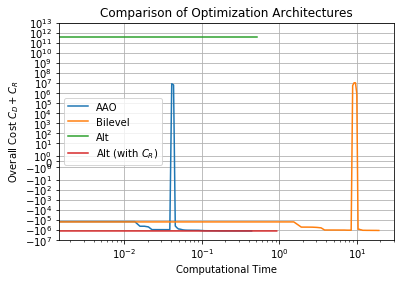

In [677]:
plt.plot(times_aao, aao_history, label="AAO")
plt.plot(times_bi, bi_history, label="Bilevel")
plt.plot(times_without, history_alt_without, label="Alt")
plt.plot(times_with, history_alt_with, label="Alt (with $C_R$)")
plt.ylim(-1e7,2e7)
plt.ylim(-1e7,1e13)
plt.ylabel("Overall Cost $C_D + C_R$")
plt.xlabel("Computational Time")
plt.yscale("symlog")
plt.xscale("log")
plt.grid()
plt.legend()
plt.title("Comparison of Optimization Architectures")
fig = plt.gcf()

In [678]:
fig.savefig('notional_comparison.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0.0)

In [679]:
tab = pd.DataFrame(columns = ["x_p", "x_a", "x_r", "x_s", "x_b", "x_c", "fun", "time"])
tab.loc['aao'] = list(result_aao['x'])+[result_aao['fun'], time_aao]
tab.loc['bilevel'] = list(result_bi['x']) + list(args['xres']) +  [result_bi['fun'], time_bi]
tab.loc['alt_without'] = list(xdes_without) + list(xres_without) + [fval_without, time_alt_without]
tab.loc['alt_with'] = list(xdes_with) + list(xres_with) + [fval_with, time_alt_with]
tab.loc['sec_with'] = list(xdes_swith) + list(xres_swith) + [fval_swith, time_swith]
tab.loc['sec_without'] = list(xdes_swithout) + list(xres_swithout) + [fval_swithout, time_swithout]

In [680]:
tab

,x_p,x_a,x_r,x_s,x_b,x_c,fun,time
aao,1.464238,1.055952,0.002155,0.408286,0.615471,10.0,-1.257429e+06,0.437725
bilevel,1.087182,0.866136,0.001418,0.221046,0.679574,10.0,-1.125949e+06,19.166589
alt_without,100.000000,80.060002,99.997182,19.939998,0.070684,10.0,4.059364e+11,0.520211
alt_with,1.464239,1.055941,0.002155,0.408298,0.615475,10.0,-1.257429e+06,0.923848
sec_with,1.287236,0.779528,0.000825,0.507709,0.716332,10.0,-1.169640e+06,0.362714
sec_without,100.000000,80.060002,99.986592,19.939998,0.070684,10.0,4.058934e+11,0.253253
